In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, RocCurveDisplay

Take a look at data

In [2]:
data = pd.read_csv('promoter_seq.csv', index_col=[0])
data

,class,name,sequence
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
...,...,...,...
101,-,799,cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...
102,-,987,gtattctcaacaagattaaccgacagattcaatctcgtggatggac...
103,-,1226,cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...
104,-,794,ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...


In [3]:
data = data.drop('name', axis=1)
print('Classes. + if promoter, - if non-promoter')
print(data['class'].value_counts())
data.info()

Classes. + if promoter, - if non-promoter
+    53
-    53
Name: class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     106 non-null    object
 1   sequence  106 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


Prepare data for model

In [4]:
def countgc(sequence):
    sequence = list(str.lower(sequence))
    gc = [1 for item in sequence if item in ['g','c']]
    return sum(gc)

countgc('atcggtacctaggAC')

8

In [5]:
def makekmer(sequence, size):
    # make list of k-mers of length 'size' from sequence
    kmers = [sequence[x:x+size] for x in range(len(sequence) - size + 1)]
    # join k-mers into sentence
    kmers = ' '.join(kmers)
    return kmers

In [6]:
# convert sequences into 'sentences' of k-mers
data['seqlen'] = data['sequence'].apply(len)
data['num_gc'] = data['sequence'].apply(countgc)
data['pct_gc'] = (data['num_gc']/data['seqlen']).round(3)
data['kmers'] = data['sequence'].apply(lambda x: makekmer(x, size=6))
# label encode class
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])
print('classes: ',le.classes_)
data

classes:  ['+' '-']


,class,sequence,seqlen,num_gc,pct_gc,kmers
0,0,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...,57,27,0.474,tactag actagc ctagca tagcaa agcaat gcaata caat...
1,0,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...,57,27,0.474,tgctat gctatc ctatcc tatcct atcctg tcctga cctg...
2,0,gtactagagaactagtgcattagcttatttttttgttatcatgcta...,57,23,0.404,gtacta tactag actaga ctagag tagaga agagaa gaga...
3,0,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...,57,21,0.368,aattgt attgtg ttgtga tgtgat gtgatg tgatgt gatg...
4,0,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...,57,24,0.421,tcgata cgataa gataat ataatt taatta aattaa atta...
...,...,...,...,...,...,...
101,1,cctcaatggcctctaaacgggtcttgaggggttttttgctgaaagg...,57,26,0.456,cctcaa ctcaat tcaatg caatgg aatggc atggcc tggc...
102,1,gtattctcaacaagattaaccgacagattcaatctcgtggatggac...,57,23,0.404,gtattc tattct attctc ttctca tctcaa ctcaac tcaa...
103,1,cgcgactacgatgagatgcctgagtgcttccgttactggattgtca...,57,31,0.544,cgcgac gcgact cgacta gactac actacg ctacga tacg...
104,1,ctcgtcctcaatggcctctaaacgggtcttgaggggttttttgctg...,57,29,0.509,ctcgtc tcgtcc cgtcct gtcctc tcctca cctcaa ctca...


0.43664464536626246

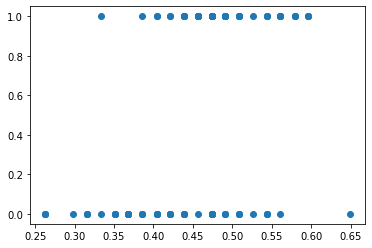

In [7]:
plt.plot(data['pct_gc'], data['class'], 'o')
data['pct_gc'].corr(data['class'])

In [8]:
# split data into train and test sets
trainx, testx, trainy, testy = train_test_split(data['kmers'], data['class'], \
                                                test_size=0.25, random_state=567, stratify=data['class'])
trainy.value_counts()

1    40
0    39
Name: class, dtype: int64

In [9]:
trainx

58     gccaat ccaatc caatca aatcaa atcaat tcaatc caat...
103    cgcgac gcgact cgacta gactac actacg ctacga tacg...
19     gcaaat caaata aaataa aataat ataatc taatca aatc...
15     aagcaa agcaaa gcaaag caaaga aaagaa aagaaa agaa...
27     tccagt ccagta cagtat agtata gtataa tataat ataa...
                             ...                        
74     catgaa atgaac tgaact gaactc aactca actcaa ctca...
36     tcgttg cgttgt gttgta ttgtat tgtata gtatat tata...
65     aactca actcaa ctcaag tcaagg caaggc aaggct aggc...
45     cactaa actaat ctaatt taattt aattta atttat ttta...
42     ttagcg tagcgg agcgga gcggat cggatc ggatcc gatc...
Name: kmers, Length: 79, dtype: object

In [10]:
# create 'bag of words' from k-mers
# features of single 6-mers 
vect = CountVectorizer(ngram_range=(1,1))
bagofwords = vect.fit_transform(trainx)

bagdf = pd.DataFrame(bagofwords.toarray())
# (# samples, # total features)
print('bag of words shape:', bagofwords.shape)

# frequency of feature occurance in train set
featfreq = bagdf.sum(axis=0)
print('frequency of features\n', featfreq.value_counts())

# drop features with only 1 occurance
cols = list(featfreq[featfreq<=1].index)
bag2 = bagdf.drop(bagdf.columns[cols], axis=1)

print('after dropping features, bag of words shape:', bag2.shape)
pd.Series(bag2.sum(axis=0)).value_counts()


bag of words shape: (79, 2042)
frequency of features
 1     1003
2      515
3      250
4      150
5       73
6       19
7       18
8        8
9        5
11       1
dtype: int64
after dropping features, bag of words shape: (79, 1039)


2     515
3     250
4     150
5      73
6      19
7      18
8       8
9       5
11      1
dtype: int64

In [11]:
# function to drop features with only 1 occurance
# input: bag of words, columns to drop if 'train' is set to False
# output: reduced bag of words dataframe, list of dropped columns (if 'train' set to True) 

def only1(bagofwords, cols=None, train=True):
    bowdf = pd.DataFrame(bagofwords.toarray())
    
    if train == True:
        # frequency of feature occurance in train set
        featfreq = bowdf.sum(axis=0)
        # list of feature columns with only 1 occurance in train set
        cols = list(featfreq[featfreq<=1].index)

        # drop features with only 1 occurance
        bow2 = bowdf.drop(bowdf.columns[cols], axis=1)

        return bow2, cols

    # when test or validation bag of words, drop columns only
    else:
        # drop features with only 1 occurance
        bow2 = bowdf.drop(bowdf.columns[cols], axis=1)

        return bow2


Model

In [12]:
# generate model
# naive bayes

score=[]

# split training data into folds
skf = StratifiedKFold(n_splits=5)
for trainidx, validx in skf.split(trainx,trainy):
    Xtrain, ytrain = trainx.iloc[trainidx], trainy.iloc[trainidx]
    Xval, yval = trainx.iloc[validx], trainy.iloc[validx]
    
    # create bag of words from train fold
    vect = CountVectorizer(ngram_range=(1,1))
    Xtrain = vect.fit_transform(Xtrain)
    
    # drop features with only 1 occurance
    Xtrain2, cols = only1(Xtrain)
    
    Xval = vect.transform(Xval)
    Xval2 = only1(Xval, cols, train=False)
   
    # fit classifier
    clf = MultinomialNB()
    clf.fit(Xtrain2, ytrain)
    
    # store score on validation set
    score.append(clf.score(Xval2, yval))
        
print('Accuracy Scores: ', score)
print('Mean Accuracy', np.mean(score))


Accuracy Scores:  [0.8125, 0.875, 0.9375, 0.8125, 1.0]
Mean Accuracy 0.8875


In [13]:
# apply model to test set
# naive bayes

# create bag of words from train set
vect = CountVectorizer(ngram_range=(1,1))
trainbow = vect.fit_transform(trainx)

# drop features with only 1 occurance
trainbow2, cols = only1(trainbow)

testbow = vect.transform(testx)
testbow2 = only1(testbow, cols, train=False)

# fit classifier
clf = MultinomialNB()
clf.fit(trainbow2, trainy)

# store score on validation set
ypred = clf.predict(testbow2)

# store probability estimates
yprob = clf.predict_proba(testbow2)

print('Accuracy: ', clf.score(testbow2, testy))

Accuracy:  0.9629629629629629


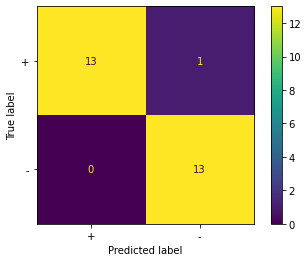

In [14]:
ConfusionMatrixDisplay.from_predictions(testy, ypred, display_labels=['+','-'])

In [15]:
# misclassified promoters
precision, recall, fscore, support = precision_recall_fscore_support(testy, ypred)
print('Precision: ', precision)
print('Recall: ', recall)

Precision:  [1.         0.92857143]
Recall:  [0.92857143 1.        ]


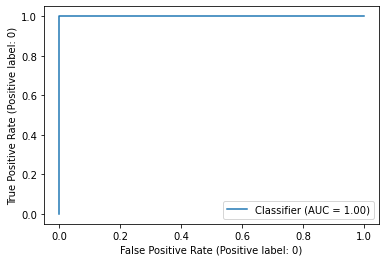

In [16]:
# naive bayes ROC 
# using probability estimates of positive class (probability of being a promoter)
RocCurveDisplay.from_predictions(testy, yprob[:,0], pos_label=0)

In [17]:
# generate model
# logistic regression, l2

score=[]

# split training data into folds
skf = StratifiedKFold(n_splits=5)
for trainidx, validx in skf.split(trainx,trainy):
    Xtrain, ytrain = trainx.iloc[trainidx], trainy.iloc[trainidx]
    Xval, yval = trainx.iloc[validx], trainy.iloc[validx]
    
    # create bag of words from train fold
    vect = CountVectorizer(ngram_range=(1,1))
    Xtrain = vect.fit_transform(Xtrain)
    
    # drop features with only 1 occurance
    Xtrain2, cols = only1(Xtrain)
    
    Xval = vect.transform(Xval)
    Xval2 = only1(Xval, cols, train=False)
   
    # fit classifier
    clf = LogisticRegression(solver='liblinear', penalty='l2')
    clf.fit(Xtrain2, ytrain)
    
    # store score on validation set
    score.append(clf.score(Xval2, yval))
    
print('Accuracy Scores: ', score)
print('Mean Accuracy', np.mean(score))


Accuracy Scores:  [0.8125, 0.8125, 0.875, 0.8125, 1.0]
Mean Accuracy 0.8625


In [18]:
# apply model to test set
# logistic regression

# create bag of words from train fold
vect = CountVectorizer(ngram_range=(1,1))
trainbow = vect.fit_transform(trainx)

# drop features with only 1 occurance
trainbow2, cols = only1(trainbow)

testbow = vect.transform(testx)
testbow2 = only1(testbow, cols, train=False)

# fit classifier
clf = LogisticRegression(solver='liblinear', penalty='l2')
clf.fit(trainbow2, trainy)

# store score on validation set
ypred = clf.predict(testbow2)

# store probability estimates
yprob = clf.predict_proba(testbow2)

print('Accuracy: ', clf.score(testbow2, testy))

Accuracy:  0.9629629629629629


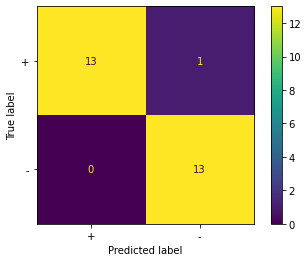

In [19]:
ConfusionMatrixDisplay.from_predictions(testy, ypred, display_labels=['+','-'])

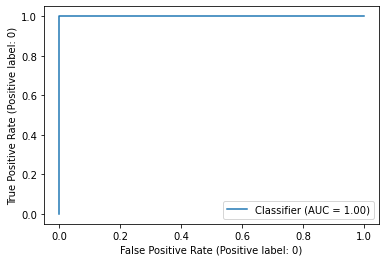

In [20]:
# logistic regression ROC 
# using probability estimates of positive class (probability of being a promoter)
#fpr, tpr, thresholds = roc_curve(testy, yprob[:,0], pos_label=0)
#plt.plot(fpr, tpr)   
RocCurveDisplay.from_predictions(testy, yprob[:,0], pos_label=0)